# Tarea 3
## Minería de Datos - IIC2433
### Rafael Fernández - 17639123

## Librerías Usadas

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Implementación de K-Means

In [223]:
class KMeans:
    def __init__(self, k_clusters, runs=10, max_iter=300, delta=10**-4, from_index=0):
        self.k_clusters = k_clusters
        self.runs = runs
        self.max_iter = max_iter
        self.delta = delta
        self.error = float("inf")
        self.centers = None
        self.clusters = None
        self.base_idx = from_index

    def fit(self, X):
        """X = 2D numpy matrix"""
        min_features = X[:, self.base_idx :].min(axis=0)
        max_features = X[:, self.base_idx :].max(axis=0)

        self.error = float("inf")
        for run in range(self.runs):
            print(f"KMeans Run #{run + 1}")
            centers = np.random.uniform(min_features, max_features, 
                                        (self.k_clusters, len(min_features)))
            clusters = self._split_clusters(centers, X)
            
            error = self._calculate_error(centers, clusters)

            error_diff = float("inf")
            iters = 0
            while error_diff > self.delta and iters < self.max_iter:
                centers = self._calculate_centers(clusters, centers)
                clusters = self._split_clusters(centers, X)
                new_error = self._calculate_error(centers, clusters)

                error_diff = error - new_error
                error = new_error
                iters += 1
            
            print(f"Run finished in {iters} iterations")
            if error < self.error:
                self.error = error
                self.centers = centers
                self.clusters = clusters


    def predict(self, X):
        return self._split_clusters(self.centers, X)

    def plot_clusters(self):
        for cluster in self.clusters:
            if cluster.size > 0:
                plt.scatter(*cluster.T)
        plt.show()

    def _split_clusters(self, centers, X):
        clusters = [[] for _ in range(len(centers))]
        for row in X:
            distances = np.zeros(len(centers))
            for idx, center in enumerate(centers):
                distances[idx] = np.linalg.norm(row[self.base_idx:] - center)

            cluster_idx = np.argmin(distances)
            clusters[cluster_idx].append(row)
        
        # To do: convert before in np array
        return [np.array(cluster) for cluster in clusters]

    def _calculate_centers(self, clusters, old_centers):
        new_centers = []
        for cluster, center in zip(clusters, old_centers):
            if cluster.size == 0:
                new_centers.append(center)
            else:
                new_centers.append(np.mean(cluster[:, self.base_idx:], axis=0))
        return np.array(new_centers)

    def _calculate_error(self, centers, clusters):
        errors = []
        for center, cluster in zip(centers, clusters):
            if cluster.size == 0:
                continue
            cluster_error = np.sum(np.linalg.norm(cluster[:, self.base_idx:] - center, axis=1) ** 2)
            errors.append(cluster_error)

        return np.sum(errors)
        

In [224]:
def gen_elbow_plot(data, k_min=2, k_max=10, runs=None, max_iters=None, delta=None):
    kwargs = {"runs" : runs, "max_iters" : max_iters, "delta" : None}
    kwargs_clear = {key : value for key, value in kwargs.items() if value is not None}
    
    errors = []
    for k in range(k_min, k_max + 1):
        kmeans = KMeans(k, **kwargs_clear)
        kmeans.fit(data)
        errors.append(kmeans.error)

    plt.plot(list(range(k_min, k_max + 1)), errors, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Graph')
    plt.show()
    print("Errors plotted", errors)

### Generar Clusters de Test

Crearemos clusters de prueba para ver si nuestra implementación de KMeans funciona correctamente

In [225]:
N_CLUSTERS = 5
X_LIMIT = 300
Y_LIMIT = 300
N_POINTS_CLUSTER = 300

x_clust_centers = np.random.uniform(0, X_LIMIT, N_CLUSTERS) 
y_clust_centers = np.random.uniform(0, Y_LIMIT, N_CLUSTERS)
clust_sizes = np.random.normal(N_POINTS_CLUSTER, 50, N_CLUSTERS)
clust_deviations = np.random.uniform(5, 15, N_CLUSTERS)

cluster_points = []
for index in range(N_CLUSTERS):
    x_center, y_center = x_clust_centers[index], y_clust_centers[index]
    size = clust_sizes[index]
    dev = clust_deviations[index]
    points_x = np.random.normal(x_center, dev, int(size))
    points_y = np.random.normal(y_center, dev, int(size))
    cluster_points.append((np.column_stack((points_x, points_y))))

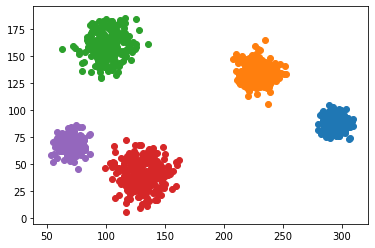

In [226]:
for cluster in cluster_points:
    plt.scatter(cluster[:,0], cluster[:,1])

## Procesamiento de Base de Datos

A continuación limpiaremos y haremos un preprocesamiento de los datos de manera que queden transformados en un formato apto para K-Means y que no se pierda en gran parte el sentido de la información

In [227]:
full_df = pd.read_csv("1-Base-de-Datos-Electoral.csv")

/home/rafael/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,23,33,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [228]:
full_df.describe()

,anoe,diainicio,mesinicio,diatermino,mestermino,anotermino,numreg,numprov,circunsen,distrito,...,vototot,voto_h,voto_m,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47
count,91888.000000,91888.000000,91888.000000,91888.000000,91888.000000,91888.000000,91888.000000,91888.000000,91888.000000,91888.000000,...,91888.000000,75578.000000,75578.000000,1.0,0.0,0.0,6.000000,4.000000e+00,1.0,2.000000e+00
mean,2003.840491,9.930818,7.264278,7.535380,7.476983,2008.756508,8.207035,27.585397,9.988366,33.159934,...,2173.806874,1077.921207,1224.854574,1.0,NaN,NaN,1004.000000,4.387090e+06,6310206.0,3.201669e+06
std,7.876691,5.047128,4.349530,2.526732,4.499966,7.806685,3.396842,11.891184,4.793248,17.814068,...,5786.357815,2734.351817,3263.627459,NaN,NaN,NaN,1099.829805,2.947031e+06,NaN,4.396135e+06
min,1989.000000,6.000000,3.000000,5.000000,3.000000,1994.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.0,NaN,NaN,0.000000,0.000000e+00,6310206.0,9.313200e+04
25%,1997.000000,6.000000,3.000000,5.000000,3.000000,2002.000000,6.000000,21.000000,7.000000,16.000000,...,131.000000,71.000000,64.000000,1.0,NaN,NaN,0.000000,4.003566e+06,6310206.0,1.647400e+06
50%,2005.000000,11.000000,3.000000,10.000000,3.000000,2010.000000,8.000000,28.000000,9.000000,35.000000,...,442.000000,240.000000,241.000000,1.0,NaN,NaN,1002.000000,5.712492e+06,6310206.0,3.201669e+06
75%,2012.000000,11.000000,12.000000,10.000000,12.000000,2016.000000,10.000000,37.000000,14.000000,48.000000,...,1615.000000,853.000000,905.000000,1.0,NaN,NaN,2007.000000,6.096015e+06,6310206.0,4.755938e+06
max,2013.000000,26.000000,12.000000,11.000000,12.000000,2022.000000,15.000000,54.000000,19.000000,60.000000,...,107355.000000,50486.000000,63386.000000,1.0,NaN,NaN,2012.000000,6.123375e+06,6310206.0,6.310206e+06


Podemos ver que las columnas "Unnamed" tienen pocos registros (6 o menos), por lo que serán eliminadas

In [229]:
df = full_df.drop(full_df.columns[list(range(41, 48))], axis=1)

Luego, eliminaremos columnas donde la información es siempre la misma ya que no sirve para separar los datos

In [230]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True, axis=1)

Ya que la información sobre cuando el período en que el representante estaría en el cargo al cual postula es irrelevante, será eliminada

In [231]:
to_drop = ['periodo', 'fechainicio', 'diainicio', 'mesinicio', 'anoinicio', 'fechatermino', 'diatermino', 'mestermino','anotermino', 'fechae']
df = df.drop(to_drop, axis=1)

Ya que sólo nos importa el espectro político, información como el nombre y sexo también será eliminada.

In [232]:
to_drop = ['nombrecand1', 'mujer', 'alcalde']
df = df.drop(to_drop, axis=1)

Sólo nos importa la cantidad de votos totales para determinar el espectro político de un lugar, por lo que eliminaremos la información que indica si son de hombres o mujeres

In [233]:
to_drop = ['voto_h', 'voto_m']
df = df.drop(to_drop, axis=1)

Tampoco hace diferencia si se llegó a segunda vuelta electoral o no.

In [234]:
to_drop = ['vueltae', 'segvuelta']
df = df.drop(to_drop, axis=1)

El órden de la lista tampoco nos interesa ya que es sorteado de manera aleatoria

In [235]:
df = df.drop("lista", axis=1)

Se eliminarán los subpactos ya que solo fueron usados en una elección

In [236]:
df = df.drop(["subpacto_text", "aux_subpacto"], axis=1)

La columna aux_folio se eliminará que es un resumen de otras variables

In [237]:
df = df.drop("aux_folio", axis=1)

Ya que nos interesa encontrar patrones a nivel comuna, eliminaremos información regional antes de usar los datos con K-Means.

In [238]:
to_drop = ['numreg', 'nombrereg', 'numprov', 'provincia', 'municipio', 'circunsen', 'distrito', 'circunprov']
df = df.drop(to_drop, axis=1)

In [239]:
df.head()

,eleccion,cargo,anoe,comuna,electo,partido_text,siglapart_text,pacto_text,aux_partido,aux_pacto,vototot
0,Presidenciales,Presidente,1989,Aisen,0,Independientes,IND,NaN,IndFP,IndFP,962
1,Presidenciales,Presidente,1989,Algarrobo,0,Independientes,IND,NaN,IndFP,IndFP,369
2,Presidenciales,Presidente,1989,Alhue,0,Independientes,IND,NaN,IndFP,IndFP,203
3,Presidenciales,Presidente,1989,Alto Del Carmen,0,Independientes,IND,NaN,IndFP,IndFP,219
4,Presidenciales,Presidente,1989,Ancud,0,Independientes,IND,NaN,IndFP,IndFP,2660


Ya que queremos determinar espectros políticos, eliminaremos a los independientes que no están asociados de ninguna forma a un partido político. Esto se puede determinar por los registros que tienen el valor 'IndFP' en la columna aux_pacto.

In [240]:
df = df[ df["aux_pacto"] != "IndFP"]

A continuación, le asignaremos un valor a cada partido político que representa su espectro pólitico. Se asociará una escala del -10 al 10, donde -10 es el extremo izquierdo del espectro y 10 es el espectro derecho.

Nos apoyaremos en la listas de partidos de cada pacto a continuación

In [241]:
for pacto in df["aux_pacto"].unique():
    print(f"PACTO: {pacto}")
    pactados = df[ df["aux_pacto"] == pacto]
    print("  -" + "\n  -".join(pactados["partido_text"].unique()))

print("-" * 50)

for pacto in df["pacto_text"].unique():
    print(f"PACTO-FULL: {pacto}")
    pactados = df[ df["pacto_text"] == pacto]
    print("  -" + "\n  -".join(pactados["partido_text"].unique()))



PACTO: AlianzaDer
  -Independientes
  -Union Democrata Independiente
  -Renovacion Nacional
  -Independientes Lista B
  -Partido Union de Centro Centro
  -Partido Nacional
  -Partido del Sur
  -Independientes Lista C
  -Independientes Lista D
  -ChilePrimero
  -Independiente
  -Independientes Lista D Subpacto RN
  -Independientes Lista D Subpacto UDI
  -Independientes Lista E
  -Independientes Lista H
PACTO: ConcertacionNM
  -Partido Democrata Cristiano
  -Partido Por la Democracia
  -Partido Socialista de Chile
  -Partido Socialista De Chile
  -Partido Radical de Chile
  -Independientes Lista A
  -Los Verdes
  -Partido Humanista
  -Social Democracia Chilena
  -Independientes Lista D
  -Partido Radical SocialDemocrata
  -Independientes Lista C
  -Independientes Lista E
  -Independientes Lista B
  -Partido Comunista de Chile
  -Partido Por La Democracia
  -Partido Comunista De Chile
  -Partido Radical Socialdemocrata
  -Independiente
  -Movimiento Amplio Social
  -Partido Alianza Humani

In [242]:
num_politico = {
 'alianza nacional de los independientes' : 3,
 'avanzada nacional': 9,
 'chileprimero': 3,
 'democracia radical': 2,
 'fuerza pais': -2,
 'fuerza del norte': -2,
 'independientes lista f' : 4,
 'los verdes': -5,
 'movimiento amplio social': -6,
 'movimiento ecologista': -2,
 'nueva alianza popular': -9,
 'partido alianza humanista verde': -4,
 'partido amplio de izquierda socialista': -7,
 'partido comunista de chile': -9,
 'partido democrata cristiano': 0,
 'partido ecologista': -4,
 'partido ecologista verde': -4,
 'partido ecologista verde del norte': -4,
 'partido fuerza del norte':-2,
 'partido humanista': -4,
 'partido igualdad': -10,
 'partido izquierda cristiana de chile': -7,
 'partido liberal': 2,
 'partido liberal de chile': 2,
 'partido movimiento de accion popular unitaria': -8,
 'partido nacional': 7,
 'partido por la democracia': -3,
 'partido progresista': -3,
 'partido radical socialdemocrata': -3,
 'partido radical socialista democratico': -4,
 'partido radical de chile': -3,
 'partido socialista de chile': -7,
 'partido union de centro centro': 0,
 'partido union de centro centro progresista':-1,
 'partido de accion regionalista de chile': 0,
 'partido del sur': 5,
 'renovacion nacional': 4,
 'social democracia chilena': -3,
 'socialista chileno': -7,
 'union democrata independiente' : 8}

Para independientes, ya que no tienen partido político, se buscará su pacto y se le asignará un valor relativo a este pacto. Para calcular la escala política de los pactos, se hará un promedio de todos los partidos políticos que han pertenecido a ese pacto.

In [243]:
num_pacto = {}
for pacto in df["aux_pacto"].unique():
    partidos = df[ df["aux_pacto"] == pacto]["partido_text"].unique()
    values = [num_politico[partido.lower()] 
              for partido in partidos if partido.lower() in num_politico]
    num_pacto[pacto] = sum(values) / len(values)

print("Valores Asignados a Pactos:")
for pacto, val in num_pacto.items():
    print(f"{pacto} : {round(val, 2)}")

Valores Asignados a Pactos:
AlianzaDer : 4.5
ConcertacionNM : -3.89
Humanista : -4.0
Izquierda : -6.86
UnionCentro : -0.5
Progresista : -2.83
NuevaConst : -6.0
Regionalista : -1.75
LibSoc : -2.5
AlianCentro : 5.5
Nacional : 4.0
Sur : 5.0
Liberal : 2.0
Norte : -2.0
Nueva_AI : 3.0
Igualdad : -10.0
ChilePrimero : 3.0


A continuación, crearemos una nueva columna 'escala_politica' donde se pondrá el valor del espectro político del partido del candidato. Si el candidato es independiente, se pondrá el valor calculado en base a su pacto.

In [244]:
def set_political_value(row):
    partido = row.partido_text.lower()
    if partido in num_politico:
        return num_politico[partido]
    return num_pacto[row.aux_pacto]

df['escala_politica'] = df.apply(set_political_value, axis=1)

Luego de asignar la escala política, quitaremos las dimensiones (columnas) que no serán usadas en el clustering. Despues de usar K-Means, recuperaremos esta información.

In [245]:
cols = set(["anoe", "escala_politica", "electo"])
to_drop = set(df.columns) - cols

df = df.drop(to_drop, axis=1)

Luego, *normalizaremos* las datos. A todas las columnas se les dejará entre **0 y 1**.

In [246]:
def scale_columns(df, cols, frange=(0, 1)):
    scaler = MinMaxScaler(frange)
    scaled_values = scaler.fit_transform(df[cols])
    df.loc[:, cols] = scaled_values


In [247]:
scale_columns(df, ["escala_politica"], (0, 1))
scale_columns(df, ["anoe", "electo"], (0, 1))

## Aplicar K-Means

In [248]:
def get_model_data(df):
    """Extrae la informacion de un dataframe para ser usada en KMeans."""
    idx = np.expand_dims(df.index.to_numpy(), axis=1)
    data = df.to_numpy()
    return np.concatenate((idx, data), 1)

Para determinar un valor de K adecuado, usaremos el conocido 'elbow method'. Probaremos valores de k entre 2 y 20, con una muestra de 1000 datos.

KMeans Run #1
Run finished in 14 iterations
KMeans Run #2
Run finished in 8 iterations
KMeans Run #3
Run finished in 9 iterations
KMeans Run #1
Run finished in 7 iterations
KMeans Run #2
Run finished in 10 iterations
KMeans Run #3
Run finished in 11 iterations
KMeans Run #1
Run finished in 13 iterations
KMeans Run #2
Run finished in 14 iterations
KMeans Run #3
Run finished in 19 iterations
KMeans Run #1
Run finished in 5 iterations
KMeans Run #2
Run finished in 65 iterations
KMeans Run #3
Run finished in 24 iterations
KMeans Run #1
Run finished in 10 iterations
KMeans Run #2
Run finished in 23 iterations
KMeans Run #3
Run finished in 51 iterations
KMeans Run #1
Run finished in 43 iterations
KMeans Run #2
Run finished in 39 iterations
KMeans Run #3
Run finished in 32 iterations
KMeans Run #1
Run finished in 35 iterations
KMeans Run #2
Run finished in 21 iterations
KMeans Run #3
Run finished in 40 iterations
KMeans Run #1
Run finished in 46 iterations
KMeans Run #2
Run finished in 17 ite

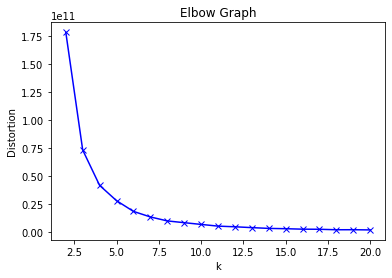

In [249]:
sample = get_model_data(df.sample(1000, random_state=1))
gen_elbow_plot(sample, 2, 20, 3)

Podemos ver que alrededor de k=7, el error comienza a disminuir lentamente, lo que que indica que es una buena cantidad de grupos para el clustering. A continuación ejecutaremos el algoritmo KMeans sobre una muestra de 10000 datos. Posteriormente analizaremos los resultados.


In [250]:
model_data = get_model_data(df.sample(10000, random_state=1))

In [251]:
kmeans = KMeans(7, runs=10, from_index=1)
kmeans.fit(model_data)
print("Error total:", kmeans.error)

KMeans Run #1
Run finished in 9 iterations
KMeans Run #2
Run finished in 9 iterations
KMeans Run #3
Run finished in 12 iterations
KMeans Run #4
Run finished in 7 iterations
KMeans Run #5
Run finished in 18 iterations
KMeans Run #6
Run finished in 9 iterations
KMeans Run #7
Run finished in 6 iterations
KMeans Run #8
Run finished in 5 iterations
KMeans Run #9
Run finished in 9 iterations
KMeans Run #10
Run finished in 10 iterations
Error total: 440.03594957376447


Veremos que registros quedaron en cada clusters para así verificar si KMeans pudo agrupar correctamente las tendencias políticas

In [252]:
for index, cluster in enumerate(kmeans.clusters):
    print("#### CLUSTER", index + 1)
    if cluster.size == 0:
        print("Cluster vacio")
        continue

    print(full_df.loc[cluster[: min((10, len(cluster))), 0]][["partido_text", "comuna", "nombrereg", "provincia", "electo"]].to_string())
    print("_" * 30)

#### CLUSTER 1
                                   partido_text          comuna                      nombrereg   provincia  electo
44288.0           Union Democrata Independiente      San Rafael                      Del Maule       Talca       0
74775.0                  Independientes Lista E         Codegua   Del Libertador Bdo. OHiggins   Cachapoal       0
91405.0                          Independientes          Antuco                     Del Biobio      Biobio       0
77058.0           Union Democrata Independiente            Lota                     Del Biobio  Concepcion       0
6722.0                      Renovacion Nacional      Lago Verde  Aisen Del Gral. Carlos Ibanez   Coihaique       0
90207.0                          Independientes         Florida                     Del Biobio  Concepcion       0
6788.0                      Renovacion Nacional        Vitacura      Metropolitana De Santiago    Santiago       0
89888.0                          Independientes          Castro  

Se puede ver que efectivamente agrupó partidos de tendencias similares y que habian sido o no electos.

A continuación, nos quedaremos solo con los clusters de los candidatos electos.

In [253]:
electos = []
for cluster in kmeans.clusters:
    first_row_idx = cluster[0][0]
    if full_df.loc[first_row_idx]["electo"] == 1:
        indexes = cluster[:, 0]
        full_part = full_df.loc[indexes]
        full_part["escala_politica"] = full_part.apply(set_political_value, axis=1)
        electos.append(full_part)

Mostraremos el promedio de la escala politica de cada cluster para determinar su posicion en el espectro político

In [254]:
for index, cluster in enumerate(electos):
    print(f"Espectro político cluster {index + 1}: {round(cluster.escala_politica.mean(), 2)}")

Espectro político cluster 1: 0.46
Espectro político cluster 2: -3.9
Espectro político cluster 3: 5.87


Podemos observar que hay un cluster de tendencia centro izquierda, otro de tendencia de centro y otro de derecha.

Ahora definiremos algunas funciones que nos permitira agregar la longitud y latitud de cada comuna.

## Visualización

In [255]:
comunas_df = pd.read_csv("Comunas_Lat-Long.csv")

def fix_comuna(row):
    comuna = row.Comuna.lower()
    letras = {'á' : 'a', 'é' : 'e', 'í' : 'i', 'ó' : 'o', 'ú' : 'u', 'ñ' : 'n'}
    for old, new in letras.items():
        comuna = comuna.replace(old, new)
    return comuna

comunas_df.Comuna = comunas_df.apply(fix_comuna, axis=1)

comunas_df.append({"Comuna" : "navarino", "Latitude" : -55.0755300, "Longitude" : -67.6554000}, ignore_index=True)

comuna_dict = {row[1].Comuna : (row[1].Latitude, row[1].Longitude) for row in comunas_df.iterrows()}
# Fix especifico para comuna que faltaba
comuna_dict["navarino"] = (-55.0755300, -67.6554000)

fix_nombre = {
 'aisen' : 'aysen',
 'cabo de hornos' : 'cabo de hornos (ex-navarino)',
 'coyhaique' : 'coihaique',
 'llay-llay' : 'llaillay',
 'marchigue' : 'marchihue',
 'ollague'   : 'ollagüe',
 'paihuano'  : 'paiguano',
 'san pedro de atacama' : 'san pedro atacama'
 }

def add_chords(row):
    comuna = row.comuna.lower()
    if comuna in fix_nombre:
        comuna = fix_nombre[comuna]
    return comuna_dict[comuna]

def add_lat(row):
    return add_chords(row)[0]

def add_lon(row):
    return add_chords(row)[1]

def add_chords_df(df):
    df["latitud"] = df.apply(add_lat, axis=1)
    df["longitud"] = df.apply(add_lon, axis=1)

A continuacion filtraremos la informacion por tipo de elección presidencial y posteriormente la graficaremos. Para que esto ultimo sea posible, se agregara la latitud y longitud a cada comuna.

In [256]:
valores = {
    "Presidenciales" : ["Presidenciales"],
    "Parlamentarias" : ["Parlamentarias-Senadores", "Parlamentarias-Diputados"],
    "Municipales"    : ["Municipales", "Municipales-Alcaldes", "Municipales-Concejales"]
}

filtrado  = {}

for key, value_list in valores.items():
    clust_list = []
    for cluster in electos:
        filt = cluster [cluster.eleccion.isin(value_list)]
        add_chords_df(filt)
        clust_list.append(filt[["latitud", "longitud"]].to_numpy())

    filtrado[key] = clust_list

/home/rafael/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/rafael/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


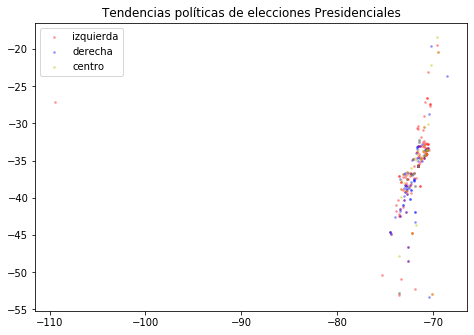

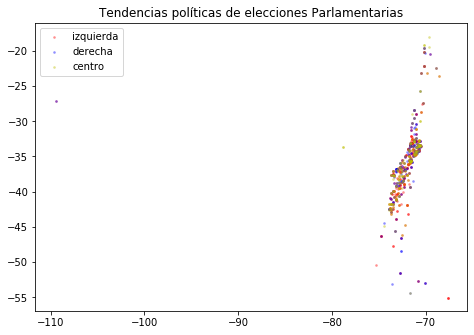

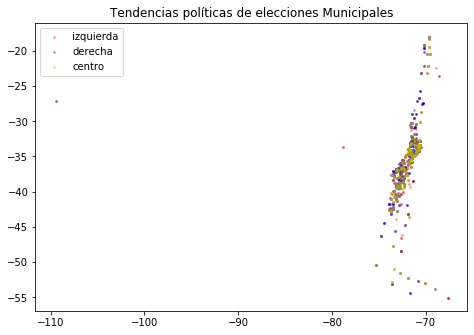

In [257]:
colors = ['r', 'b', 'y']
labels = ['izquierda', 'derecha', 'centro']

for key, point_list in filtrado.items():
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title(f"Tendencias políticas de elecciones {key}")
    # ax.set_xlim(-77, -68)
    for index, cluster in enumerate(point_list):
        ax.scatter(cluster[:, 1], cluster[:, 0], color=colors[index], s=3, label=labels[index], alpha=0.3)
    ax.legend()
    plt.show()

## Análisis

A primera vista, se puede ver que hay una tendencia general hacia posiciones más centrales (tonos de amarillo). Esto se hace especialmente notorio en la zona central del país.
Para el caso de las elecciones Presidenciales, se puede notar una tendencia hacia la izquierda en la zona centro-sur del país.

En los tres tipos de elecciones se puede ver una ligera tendencia a la derecha en la zona norte del país.
A nivel general, se puede ver que los puntos de tonos naranjos (mezcla de izquierda - centro) son algo más frecuentes que los de tonos verdes (mezcla de derecha - centro), por lo que a nivel general se podría marcar una tendencia de centro con una pequeña tendencia hacia la izquierda.